In [ ]:
# Samuel Göbel
# Master Thesis Data Science and Society May 2025
# Tilburg University

# Burnout Prediction Among Medical Students


# Experiment 4: Regression mbi_total prediction

In [ ]:
# ------------------------------------------------------------------------------
# Overview Experiment 4:
# ------------------------------------------------------------------------------



# Target variable mbi_total, excluding any mbi-related variables and 'burnout'

# Models to compare: dt, rf, svr, xgboost, and tabnet

# randomized 80/20 train/test split

# model training via 5 fold cross validation


# randomized hyperparameter tuning via 5 fold cross validation,


# Train model with best hyperparameters on the entire training set



In [ ]:
!pip install pytorch-tabnet
!pip install optuna # Hyperparameter tuning

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model selection
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    train_test_split
)

# Models (Regression)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

# Evaluation metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Model interpretation
from sklearn.inspection import permutation_importance

# Optimization
import optuna


In [ ]:
# using the precprocessed clean data
data = pd.read_csv("/content/drive/MyDrive/Master Thesis 2025/BurnoutDataset/data_encoded_clean.csv")


In [ ]:
# Specifying target and predictors

data = pd.read_csv("/content/drive/MyDrive/Master Thesis 2025/BurnoutDataset/data_encoded_clean.csv")



# Drop MBI-related columns
mbi_columns = ['mbi_ex', 'mbi_cy', 'mbi_ea', 'mbi_ea_rev', 'burnout']
df_filtered = data.drop(columns=mbi_columns)



# Define features and target
X = df_filtered.drop(columns=['mbi_total'])
y = df_filtered['mbi_total']



# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.describe(), y_test.describe()


((708, 23),
 (178, 23),
 count    708.000000
 mean      38.683616
 std       11.930322
 min       13.000000
 25%       30.000000
 50%       38.000000
 75%       47.000000
 max       77.000000
 Name: mbi_total, dtype: float64,
 count    178.000000
 mean      39.011236
 std       11.908782
 min        9.000000
 25%       31.000000
 50%       39.000000
 75%       45.000000
 max       78.000000
 Name: mbi_total, dtype: float64)

# Decision Tree

In [ ]:
# ------------------------------------------------------------------------------
# Decision Tree baseline no cross validation
# ------------------------------------------------------------------------------


# Initialize Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)





# Train on the training data
dt_model.fit(X_train, y_train)





# Predict on the test set
y_pred_dt = dt_model.predict(X_test)






# Evaluate model performance (compatible with older scikit-learn)
r2_dt = r2_score(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = mse_dt ** 0.5  # Compute RMSE manually
mae_dt = mean_absolute_error(y_test, y_pred_dt)






# Print metrics
print(f"R²: {r2_dt:.3f}")
print(f"RMSE: {rmse_dt:.2f}")
print(f"MAE: {mae_dt:.2f}")


R²: -0.209
RMSE: 13.06
MAE: 9.72


In [ ]:

# ------------------------------------------------------------------------------
# Decision Tree randomized hyperparameter tuning 5 fold cv and test evaluation




# Define parameter grid for Decision Tree
param_dist = {
    'max_depth': [None] + list(np.arange(2, 30)),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}







# Initialize base model
dt_base = DecisionTreeRegressor(random_state=42)







# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=dt_base,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)






# Fit on training data
random_search.fit(X_train, y_train)






# Best model and hyperparameters
best_dt = random_search.best_estimator_
best_params = random_search.best_params_






# Retrain on full training set
# Predict on test set
y_pred_best = best_dt.predict(X_test)






# Evaluate
r2_best = r2_score(y_test, y_pred_best)
rmse_best = mean_squared_error(y_test, y_pred_best) ** 0.5
mae_best = mean_absolute_error(y_test, y_pred_best)






# Print results
print("Best Hyperparameters:", best_params)
print(f"R² (Test): {r2_best:.3f}")
print(f"RMSE (Test): {rmse_best:.2f}")
print(f"MAE (Test): {mae_best:.2f}")


Best Hyperparameters: {'min_samples_split': np.int64(17), 'min_samples_leaf': np.int64(5), 'max_features': None, 'max_depth': np.int64(2), 'criterion': 'friedman_mse'}
R² (Test): 0.276
RMSE (Test): 10.10
MAE (Test): 7.75


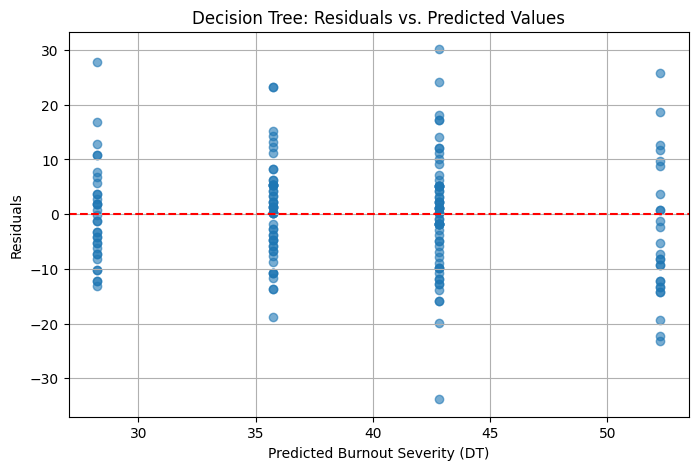

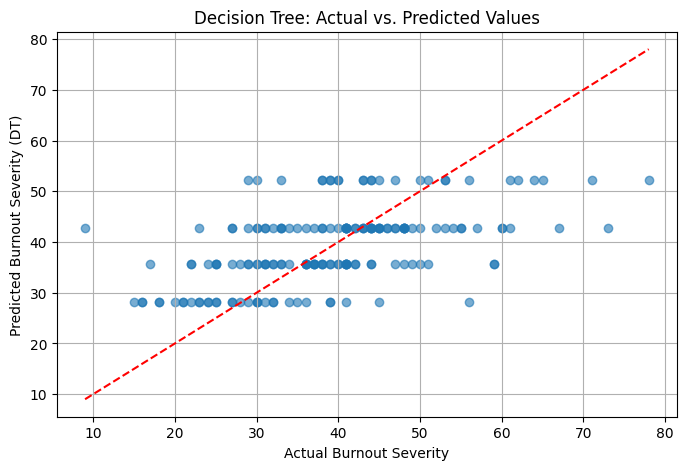

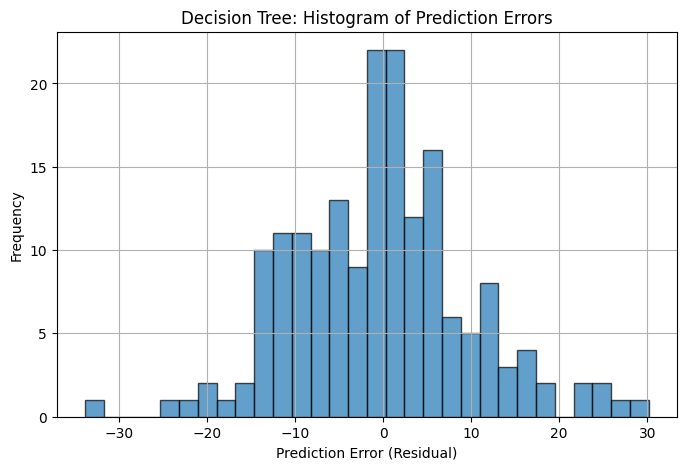

In [ ]:
# Error Analysis DT-----------------


# Calculate residuals
residuals = y_test - y_pred_best







# Residuals vs Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Burnout Severity (DT)")
plt.ylabel("Residuals")
plt.title("Decision Tree: Residuals vs. Predicted Values")
plt.grid(True)
plt.show()








# Actual vs Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Burnout Severity")
plt.ylabel("Predicted Burnout Severity (DT)")
plt.title("Decision Tree: Actual vs. Predicted Values")
plt.grid(True)
plt.show()








# Histogram of Residuals ----
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Decision Tree: Histogram of Prediction Errors")
plt.grid(True)
plt.show()

In [ ]:
# Count how many unique values your model is predicting
unique_preds = np.unique(y_pred_best)
print("Number of unique predictions:", len(unique_preds))
print("Unique predicted values:", unique_preds)


Number of unique predictions: 4
Unique predicted values: [28.22142857 35.73245614 42.8365019  52.25974026]


# Random Forest

In [ ]:
# ------------------------------------------------------------------------------
# Random Forest baseline no cross-validation
# ------------------------------------------------------------------------------

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)






# Train on the training data
rf_model.fit(X_train, y_train)





# Predict on the test set
y_pred_rf = rf_model.predict(X_test)





# Evaluate model performance
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
mae_rf = mean_absolute_error(y_test, y_pred_rf)




# Print or return metrics
print(f"R²: {r2_rf:.3f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")


R²: 0.372
RMSE: 9.41
MAE: 7.09


In [ ]:
# ------------------------------------------------------------------------------
# Random Forest randomized hyperparameter tuning with 5-fold CV and test eval




# Define parameter grid for Random Forest
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None] + list(np.arange(3, 30, 3)),
    'min_samples_split': np.arange(2, 15),
    'min_samples_leaf': np.arange(1, 15),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}







# Initialize base model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)




# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)






# Fit on training data
random_search.fit(X_train, y_train)







# Best model and hyperparameters
best_rf = random_search.best_estimator_
best_params = random_search.best_params_




# Predict on test set
y_pred_rf = best_rf.predict(X_test)






# Evaluate
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
mae_rf = mean_absolute_error(y_test, y_pred_rf)





# Print results
print("Best Hyperparameters:", best_params)
print(f"R² (Test): {r2_rf:.3f}")
print(f"RMSE (Test): {rmse_rf:.2f}")
print(f"MAE (Test): {mae_rf:.2f}")


Best Hyperparameters: {'n_estimators': np.int64(150), 'min_samples_split': np.int64(13), 'min_samples_leaf': np.int64(2), 'max_features': 'sqrt', 'max_depth': np.int64(24), 'bootstrap': True}
R² (Test): 0.376
RMSE (Test): 9.38
MAE (Test): 7.24


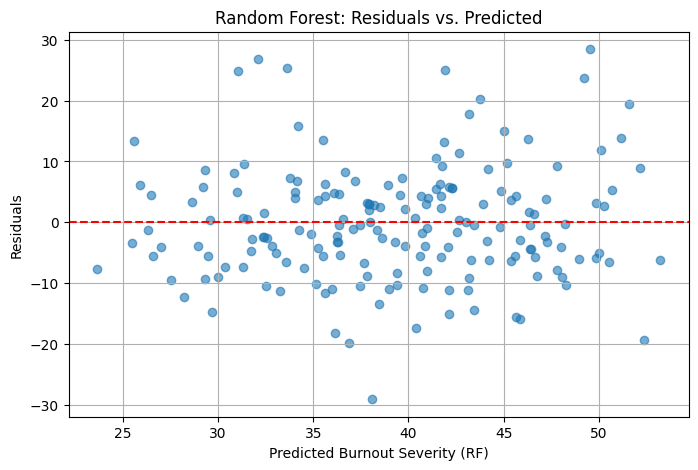

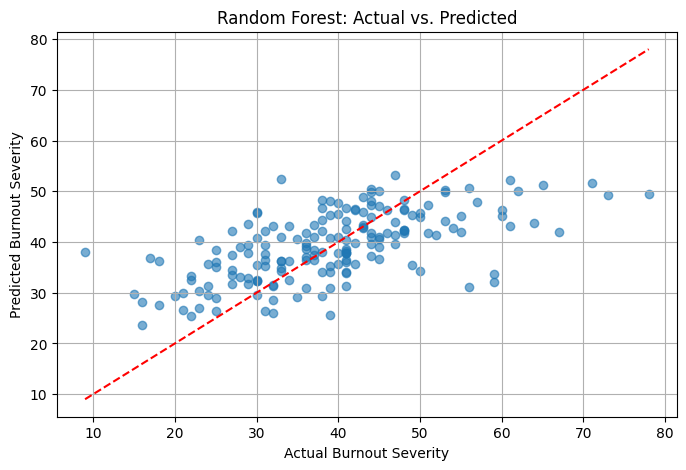

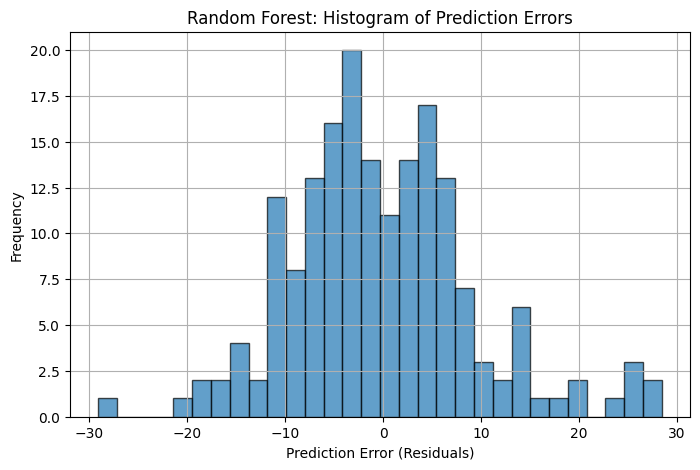

In [ ]:
# Error Analsis RF ----------------------------------


import matplotlib.pyplot as plt
import numpy as np





# Calculate residuals
residuals_rf = y_test - y_pred_rf






# Residuals vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Burnout Severity (RF)")
plt.ylabel("Residuals")
plt.title("Random Forest: Residuals vs. Predicted")
plt.grid(True)
plt.show()






# Actual vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Burnout Severity")
plt.ylabel("Predicted Burnout Severity")
plt.title("Random Forest: Actual vs. Predicted")
plt.grid(True)
plt.show()





# Histogram of Residuals ----
plt.figure(figsize=(8, 5))
plt.hist(residuals_rf, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Random Forest: Histogram of Prediction Errors")
plt.grid(True)
plt.show()


In [ ]:
# Count how many unique values your model is predicting
unique_preds = np.unique(y_pred_rf)
print("Number of unique predictions:", len(unique_preds))
print("Unique predicted values:", unique_preds)


Number of unique predictions: 178
Unique predicted values: [23.63273592 25.46613369 25.60322886 25.91896688 26.33853102 26.4886816
 26.57105351 27.0236068  27.51113203 28.22252828 28.62673766 28.95558654
 29.2314792  29.32065914 29.3279355  29.46993741 29.60297079 29.67555112
 30.00882566 30.36719454 30.86019197 30.98873633 31.06963791 31.29833323
 31.31927199 31.36498145 31.51985605 31.72271848 31.77673062 32.12457032
 32.3850338  32.39417499 32.42636923 32.53866222 32.56886072 32.83633345
 33.05095733 33.24674049 33.55473739 33.61266141 33.78567381 34.06355195
 34.06568555 34.1549945  34.20305067 34.27666598 34.52064834 34.89561567
 35.14417167 35.23287293 35.25551961 35.51948519 35.53961663 35.59607668
 35.60392082 35.63919893 35.96641119 36.10424866 36.16196177 36.24433523
 36.25595284 36.29521303 36.34893234 36.37772844 36.40193156 36.53778576
 36.66334747 36.87926241 37.10688698 37.20050706 37.45062325 37.45500049
 37.65676989 37.80072943 37.84926332 37.91136628 37.91429956 37.92

# SVR

In [ ]:
# ------------------------------------------------------------------------------
# SVR baseline no cross-validation
# ------------------------------------------------------------------------------

# Initialize SVR model
svr_model = SVR()





# Train on the training data
svr_model.fit(X_train, y_train)





# Predict on the test set
y_pred_svr = svr_model.predict(X_test)





# Evaluate model performance
r2_svr = r2_score(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = mse_svr ** 0.5
mae_svr = mean_absolute_error(y_test, y_pred_svr)





# Print results
print(f"R²: {r2_svr:.3f}")
print(f"RMSE: {rmse_svr:.2f}")
print(f"MAE: {mae_svr:.2f}")


R²: 0.329
RMSE: 9.73
MAE: 7.41


In [ ]:
# ------------------------------------------------------------------------------
# SVR randomized hyperparameter tuning with 5-fold CV and test evaluation



# Define parameter grid for SVR
param_dist = {
    'C': np.logspace(-2, 2, 10),           # Regularization strength
    'epsilon': np.linspace(0.01, 1, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 5)),  # Kernel coefficient
    'kernel': ['rbf']
}





# Initialize base SVR model
svr_base = SVR()





# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=svr_base,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)





# Fit on training data
random_search.fit(X_train, y_train)





# Best model and hyperparameters
best_svr = random_search.best_estimator_
best_params = random_search.best_params_





# Predict on test set
y_pred_svr = best_svr.predict(X_test)





# Evaluate
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = mean_squared_error(y_test, y_pred_svr) ** 0.5
mae_svr = mean_absolute_error(y_test, y_pred_svr)





# Print results
print("Best Hyperparameters:", best_params)
print(f"R² (Test): {r2_svr:.3f}")
print(f"RMSE (Test): {rmse_svr:.2f}")
print(f"MAE (Test): {mae_svr:.2f}")


Best Hyperparameters: {'kernel': 'rbf', 'gamma': np.float64(0.0017782794100389228), 'epsilon': np.float64(0.12), 'C': np.float64(35.93813663804626)}
R² (Test): 0.410
RMSE (Test): 9.12
MAE (Test): 6.92


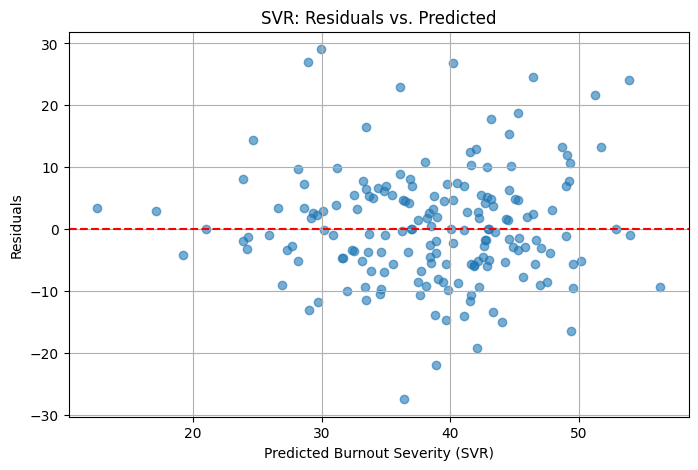

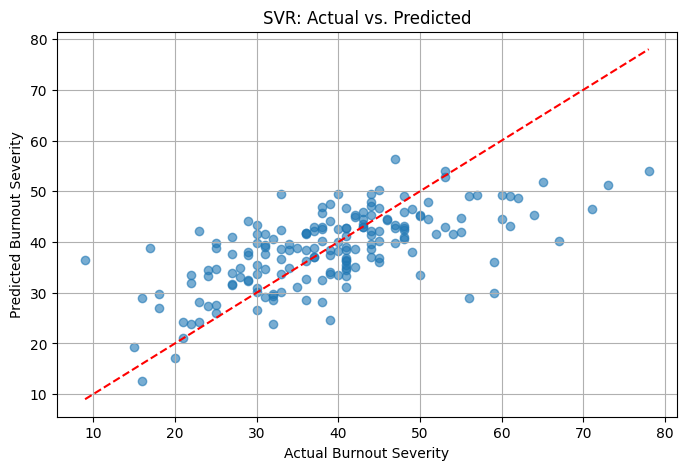

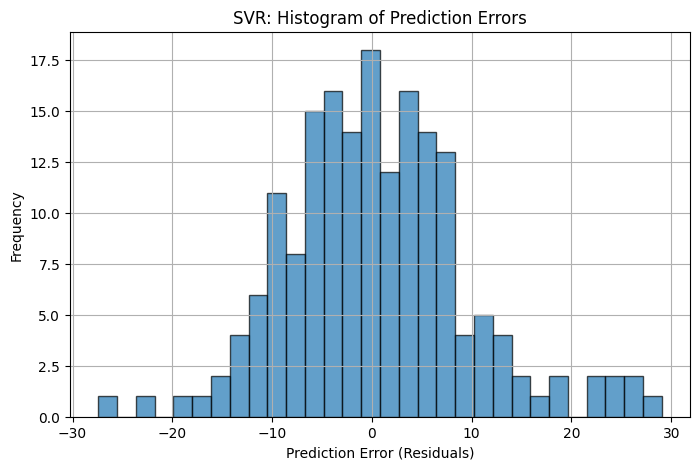

In [ ]:
# Error analysis SVR -----------------------------------------



# Calculate residuals
residuals_svr = y_test - y_pred_svr








# Residuals vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_svr, residuals_svr, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Burnout Severity (SVR)")
plt.ylabel("Residuals")
plt.title("SVR: Residuals vs. Predicted")
plt.grid(True)
plt.show()







# Actual vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_svr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Burnout Severity")
plt.ylabel("Predicted Burnout Severity")
plt.title("SVR: Actual vs. Predicted")
plt.grid(True)
plt.show()







# Histogram of Residuals ----
plt.figure(figsize=(8, 5))
plt.hist(residuals_svr, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("SVR: Histogram of Prediction Errors")
plt.grid(True)
plt.show()


In [ ]:
# Count how many unique values your model is predicting
unique_preds = np.unique(y_pred_svr)
print("Number of unique predictions:", len(unique_preds))
print("Unique predicted values:", unique_preds)


Number of unique predictions: 178
Unique predicted values: [12.49799813 17.09046678 19.22103903 20.97605309 23.89698939 23.90685764
 24.22537541 24.28724979 24.65367375 25.93646459 26.58119534 26.94995119
 27.29412038 27.66575928 28.19356056 28.19459902 28.63270575 28.63632973
 28.92655661 28.99243637 29.15208465 29.3215048  29.66244988 29.70330713
 29.93999705 30.12999159 30.14945959 30.85379358 31.10554143 31.15571419
 31.5878162  31.64900363 31.95055295 32.3624397  32.53230778 32.5397717
 32.77936568 33.10721974 33.2033843  33.385189   33.4157989  33.41635147
 33.42697991 33.62802662 33.70058252 33.71869338 33.80337263 34.02611592
 34.39455658 34.51714048 34.60508645 34.62038863 34.8749561  34.87522385
 34.88837395 35.03632281 35.47999397 35.54176167 36.08282961 36.08495406
 36.21064331 36.34505394 36.43172969 36.4440687  36.71518485 36.7582245
 36.90559651 36.95915449 37.01411183 37.02677295 37.52600263 37.52999267
 37.61489142 37.72313879 38.07359082 38.11933254 38.19986297 38.338

# XGBoost

In [ ]:
# ------------------------------------------------------------------------------
# XGBoost Regressor baseline (no cross-validation)
# ------------------------------------------------------------------------------


# Initialize XGBoost Regressor
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',  # regression
    random_state=42,
    n_jobs=-1
)






# Train on the training data
xgb_regressor.fit(X_train, y_train)





# Predict on the test set
y_pred_xgb = xgb_regressor.predict(X_test)






# Evaluate model performance
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)






# Print results
print(f"R²: {r2_xgb:.3f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")


R²: 0.211
RMSE: 10.55
MAE: 8.09


In [ ]:
# ------------------------------------------------------------------------------
# XGBoost Regressor randomized hyperparameter tuning with 5-fold CV and test evaluation






# Define parameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}






# Initialize base XGBoost model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)







# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)






# Fit on training data
random_search.fit(X_train, y_train)





# Best model and hyperparameters
best_xgb = random_search.best_estimator_
best_params = random_search.best_params_





# Predict on test set
y_pred_xgb = best_xgb.predict(X_test)






# Evaluate
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)








# Print results
print("Best Hyperparameters:", best_params)
print(f"R² (Test): {r2_xgb:.3f}")
print(f"RMSE (Test): {rmse_xgb:.2f}")
print(f"MAE (Test): {mae_xgb:.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': np.float64(1.0), 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': np.float64(0.042222222222222223), 'gamma': 0, 'colsample_bytree': np.float64(0.8)}
R² (Test): 0.372
RMSE (Test): 9.41
MAE (Test): 7.17


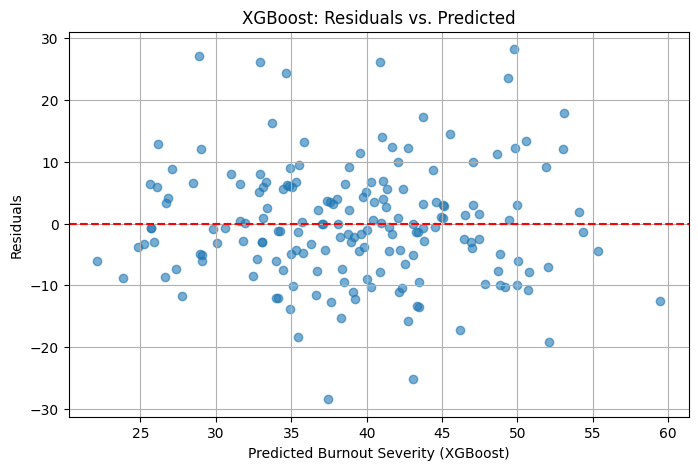

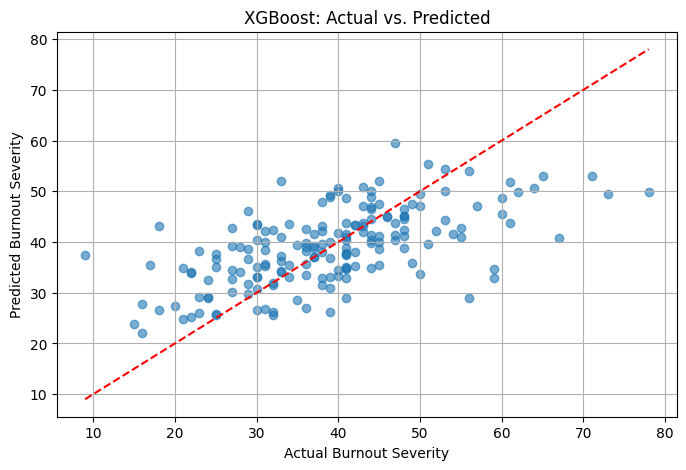

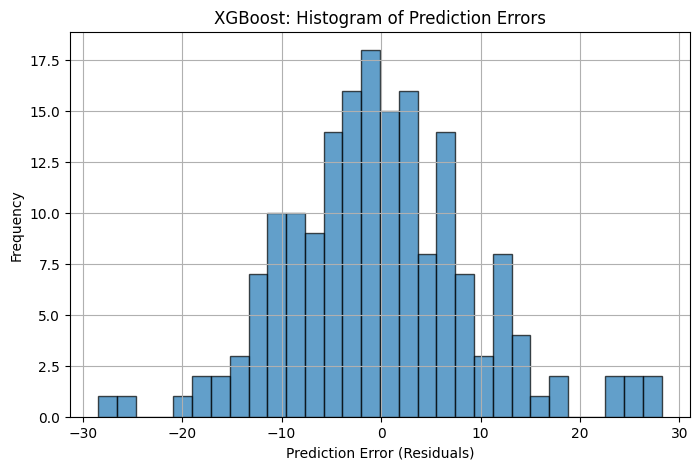

In [ ]:
# ------------------------------------------------------------------------------
# Error Analysis for XGBoost Regressor






# Calculate residuals
residuals_xgb = y_test - y_pred_xgb







# Residuals vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Burnout Severity (XGBoost)")
plt.ylabel("Residuals")
plt.title("XGBoost: Residuals vs. Predicted")
plt.grid(True)
plt.show()






# Actual vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Burnout Severity")
plt.ylabel("Predicted Burnout Severity")
plt.title("XGBoost: Actual vs. Predicted")
plt.grid(True)
plt.show()







# Histogram of Residuals ----
plt.figure(figsize=(8, 5))
plt.hist(residuals_xgb, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("XGBoost: Histogram of Prediction Errors")
plt.grid(True)
plt.show()


# TabNet

In [ ]:
!pip install pytorch-tabnet
!pip install optuna # Hyperparameter tuning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# ------------------------------------------------------------------------------
# TabNet baseline no cross-validation
# ------------------------------------------------------------------------------

# -------------------------------------------------
# preprocess datatypes
X_train_tabnet = X_train.copy()
X_test_tabnet = X_test.copy()

for col in X_train_tabnet.select_dtypes(include='bool').columns:
    X_train_tabnet[col] = X_train_tabnet[col].astype(int)
    X_test_tabnet[col] = X_test_tabnet[col].astype(int)





# Convert to numpy arrays
X_train_np = X_train_tabnet.values
y_train_np = y_train.values.reshape(-1, 1)
X_test_np = X_test_tabnet.values
y_test_np = y_test.values.reshape(-1, 1)
# -------------------------------------------------





# Initialize TabNet Regressor (set verbosity here)
tabnet_model = TabNetRegressor(seed=42, verbose=0)






# Train on the training data
tabnet_model.fit(
    X_train_np, y_train_np,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)






# Predict on the test set
y_pred_tabnet = tabnet_model.predict(X_test_np)






# Evaluate model performance
r2_tabnet = r2_score(y_test_np, y_pred_tabnet)
rmse_tabnet = mean_squared_error(y_test_np, y_pred_tabnet) ** 0.5
mae_tabnet = mean_absolute_error(y_test_np, y_pred_tabnet)







# Print results
print(f"R²: {r2_tabnet:.3f}")
print(f"RMSE: {rmse_tabnet:.2f}")
print(f"MAE: {mae_tabnet:.2f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


R²: 0.275
RMSE: 10.11
MAE: 7.64


In [ ]:
# ------------------------------------------------------------------------------
# TabNet randomized hyperparameter tuning with Optuna and 5-fold CV + test eval





# ---------------------------------------------------------
# Define Optuna objective function with 5-fold CV

def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 8, 64, step=8),
        "n_a": trial.suggest_int("n_a", 8, 64, step=8),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-1, log=True),
        "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),  # store flat
        "mask_type": trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X_train_np):
        X_tr, X_val = X_train_np[train_idx], X_train_np[val_idx]
        y_tr, y_val = y_train_np[train_idx], y_train_np[val_idx]

        model = TabNetRegressor(
            n_d=params["n_d"],
            n_a=params["n_a"],
            n_steps=params["n_steps"],
            gamma=params["gamma"],
            lambda_sparse=params["lambda_sparse"],
            optimizer_params={"lr": params["lr"]},
            mask_type=params["mask_type"],
            seed=42,
            verbose=0
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric=["rmse"],
            max_epochs=200,
            patience=20,
            batch_size=256,
            virtual_batch_size=128
        )

        y_pred = model.predict(X_val)
        score = r2_score(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)







# ---------------------------------------------------------
# Run the Optuna study

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=3600)  # Adjust as needed









# best model on the full training set
best_params = study.best_trial.params






# Extract learning rate and reformat
lr = best_params.pop("lr")






# Update with correct TabNet init args
best_params.update({
    "optimizer_params": {"lr": lr},
    "seed": 42,
    "verbose": 0
})






# Instantiate best model
best_tabnet = TabNetRegressor(**best_params)






# Fit on full training data
best_tabnet.fit(
    X_train_np, y_train_np,
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)








# Predict and evaluate on test set

y_pred_tabnet = best_tabnet.predict(X_test_np)

r2_tabnet = r2_score(y_test_np, y_pred_tabnet)
rmse_tabnet = mean_squared_error(y_test_np, y_pred_tabnet) ** 0.5
mae_tabnet = mean_absolute_error(y_test_np, y_pred_tabnet)







# results

print("Best Hyperparameters:", study.best_params)
print(f"R² (Test): {r2_tabnet:.3f}")
print(f"RMSE (Test): {rmse_tabnet:.2f}")
print(f"MAE (Test): {mae_tabnet:.2f}")


[I 2025-04-13 19:50:49,890] A new study created in memory with name: no-name-d3e4eb3b-637c-4151-9c7d-8b6caca6ee57



Early stopping occurred at epoch 179 with best_epoch = 159 and best_val_0_rmse = 10.90178


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 183 and best_val_0_rmse = 10.3637


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 12.75864


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 197 and best_val_0_rmse = 9.91938


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 19:53:01,280] Trial 0 finished with value: 0.16305721998214723 and parameters: {'n_d': 16, 'n_a': 56, 'n_steps': 6, 'gamma': 1.6824059169993812, 'lambda_sparse': 0.020853717026077617, 'lr': 0.0020177118335674565, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.16305721998214723.


Stop training because you reached max_epochs = 200 with best_epoch = 194 and best_val_0_rmse = 10.20928

Early stopping occurred at epoch 95 with best_epoch = 75 and best_val_0_rmse = 11.66547


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 102 with best_epoch = 82 and best_val_0_rmse = 9.29607


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 116 with best_epoch = 96 and best_val_0_rmse = 12.2362


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 114 with best_epoch = 94 and best_val_0_rmse = 9.63331


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 19:54:28,540] Trial 1 finished with value: 0.18509678840637206 and parameters: {'n_d': 64, 'n_a': 56, 'n_steps': 8, 'gamma': 1.6671510234047546, 'lambda_sparse': 0.028326238826375544, 'lr': 0.0031509094411871718, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 0.18509678840637206.



Early stopping occurred at epoch 125 with best_epoch = 105 and best_val_0_rmse = 10.64853
Stop training because you reached max_epochs = 200 with best_epoch = 196 and best_val_0_rmse = 11.25006


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 191 and best_val_0_rmse = 10.8878


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 199 with best_epoch = 179 and best_val_0_rmse = 13.33356


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 189 and best_val_0_rmse = 10.61687


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 19:57:41,337] Trial 2 finished with value: 0.0922550916671753 and parameters: {'n_d': 24, 'n_a': 56, 'n_steps': 10, 'gamma': 1.0389739761551522, 'lambda_sparse': 0.0001957412252953546, 'lr': 0.0009357847876108791, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 0.18509678840637206.


Stop training because you reached max_epochs = 200 with best_epoch = 192 and best_val_0_rmse = 10.25464
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 16.2273


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 14.2275


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 18.04412


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 15.38271


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 19:58:54,947] Trial 3 finished with value: -0.7900334596633911 and parameters: {'n_d': 24, 'n_a': 32, 'n_steps': 3, 'gamma': 1.2210015204942903, 'lambda_sparse': 3.93326108828736e-05, 'lr': 0.0009125182846323515, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 0.18509678840637206.


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 15.30926

Early stopping occurred at epoch 146 with best_epoch = 126 and best_val_0_rmse = 10.04622


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 184 and best_val_0_rmse = 9.08559


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 163 with best_epoch = 143 and best_val_0_rmse = 11.79665


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 123 with best_epoch = 103 and best_val_0_rmse = 9.84162


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:00:18,528] Trial 4 finished with value: 0.2863595008850098 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.7123787836972895, 'lambda_sparse': 0.00047357954169279654, 'lr': 0.005088988644684088, 'mask_type': 'sparsemax'}. Best is trial 4 with value: 0.2863595008850098.



Early stopping occurred at epoch 171 with best_epoch = 151 and best_val_0_rmse = 9.19412
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 20.99015


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_rmse = 21.21102


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 196 and best_val_0_rmse = 23.15809


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 197 and best_val_0_rmse = 22.88857


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:03:12,724] Trial 5 finished with value: -2.5703850269317625 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 9, 'gamma': 1.8736032579372255, 'lambda_sparse': 0.023948398219710572, 'lr': 0.0006767276957308419, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.2863595008850098.


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 23.05644
Stop training because you reached max_epochs = 200 with best_epoch = 192 and best_val_0_rmse = 9.78942


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 176 with best_epoch = 156 and best_val_0_rmse = 8.96202


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 176 with best_epoch = 156 and best_val_0_rmse = 12.21618


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 193 with best_epoch = 173 and best_val_0_rmse = 9.18806


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:05:37,901] Trial 6 finished with value: 0.3024969696998596 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 8, 'gamma': 1.3564804422478935, 'lambda_sparse': 0.0002027679782020636, 'lr': 0.0036792400042352, 'mask_type': 'entmax'}. Best is trial 6 with value: 0.3024969696998596.


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_rmse = 9.28376

Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_rmse = 44.72059


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_rmse = 41.89771


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_rmse = 45.95583


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_rmse = 42.81951


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:06:14,597] Trial 7 finished with value: -12.777023696899414 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 9, 'gamma': 1.5380613922869557, 'lambda_sparse': 3.690646066554468e-05, 'lr': 0.000217960501812383, 'mask_type': 'entmax'}. Best is trial 6 with value: 0.3024969696998596.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 43.84292
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 31.30485


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 29.4319


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 32.62142


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 29.13067


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:08:18,818] Trial 8 finished with value: -5.717054843902588 and parameters: {'n_d': 40, 'n_a': 32, 'n_steps': 6, 'gamma': 1.1853805950941778, 'lambda_sparse': 0.018615666815375412, 'lr': 0.0002902863983761979, 'mask_type': 'sparsemax'}. Best is trial 6 with value: 0.3024969696998596.


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 30.7105
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 33.18908


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_rmse = 29.83877


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 32.26785


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 28.95769


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:11:26,315] Trial 9 finished with value: -6.048124599456787 and parameters: {'n_d': 24, 'n_a': 48, 'n_steps': 10, 'gamma': 1.589266860000595, 'lambda_sparse': 3.6966031889953905e-05, 'lr': 0.0004667658327741591, 'mask_type': 'sparsemax'}. Best is trial 6 with value: 0.3024969696998596.


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_rmse = 32.60017

Early stopping occurred at epoch 101 with best_epoch = 81 and best_val_0_rmse = 9.75223


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 94 with best_epoch = 74 and best_val_0_rmse = 8.83685


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 53 and best_val_0_rmse = 12.19892


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 85 with best_epoch = 65 and best_val_0_rmse = 9.34014


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:12:29,916] Trial 10 finished with value: 0.3050602555274963 and parameters: {'n_d': 56, 'n_a': 8, 'n_steps': 7, 'gamma': 1.368564902953011, 'lambda_sparse': 0.0030078254776575992, 'lr': 0.009521390720529318, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.3050602555274963.



Early stopping occurred at epoch 111 with best_epoch = 91 and best_val_0_rmse = 9.2071

Early stopping occurred at epoch 100 with best_epoch = 80 and best_val_0_rmse = 9.63753


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 115 with best_epoch = 95 and best_val_0_rmse = 9.27572


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 95 with best_epoch = 75 and best_val_0_rmse = 11.84848


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 53 and best_val_0_rmse = 9.67004


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:13:35,486] Trial 11 finished with value: 0.2996649980545044 and parameters: {'n_d': 56, 'n_a': 8, 'n_steps': 7, 'gamma': 1.376100239674922, 'lambda_sparse': 0.0030948061803522174, 'lr': 0.00918889011856907, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.3050602555274963.



Early stopping occurred at epoch 98 with best_epoch = 78 and best_val_0_rmse = 9.03689

Early stopping occurred at epoch 80 with best_epoch = 60 and best_val_0_rmse = 9.04484


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 122 with best_epoch = 102 and best_val_0_rmse = 8.37822


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 123 with best_epoch = 103 and best_val_0_rmse = 11.76702


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 74 with best_epoch = 54 and best_val_0_rmse = 9.1443


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:14:45,303] Trial 12 finished with value: 0.3473954677581787 and parameters: {'n_d': 48, 'n_a': 16, 'n_steps': 7, 'gamma': 1.3886845135108914, 'lambda_sparse': 0.002740160335328172, 'lr': 0.007851269310376507, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 108 with best_epoch = 88 and best_val_0_rmse = 9.45529

Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_rmse = 11.76256


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 72 and best_val_0_rmse = 10.2548


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 101 with best_epoch = 81 and best_val_0_rmse = 12.73379


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 55 and best_val_0_rmse = 9.88955


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:15:28,853] Trial 13 finished with value: 0.13899964094161987 and parameters: {'n_d': 48, 'n_a': 8, 'n_steps': 4, 'gamma': 1.3603032686968963, 'lambda_sparse': 0.002631948533717449, 'lr': 0.008039280894566483, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 132 with best_epoch = 112 and best_val_0_rmse = 10.31034

Early stopping occurred at epoch 160 with best_epoch = 140 and best_val_0_rmse = 11.44138


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 187 with best_epoch = 167 and best_val_0_rmse = 9.71238


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 169 with best_epoch = 149 and best_val_0_rmse = 12.39952


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 187 and best_val_0_rmse = 9.83754


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:17:33,453] Trial 14 finished with value: 0.20310035943984986 and parameters: {'n_d': 48, 'n_a': 16, 'n_steps': 7, 'gamma': 1.418079979869258, 'lambda_sparse': 0.0040350158227371955, 'lr': 0.0019145406606215503, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 184 with best_epoch = 164 and best_val_0_rmse = 9.43169
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 36.94361


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_rmse = 39.67678


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 36.98527


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 34.49395


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:18:46,782] Trial 15 finished with value: -9.424709701538086 and parameters: {'n_d': 64, 'n_a': 24, 'n_steps': 5, 'gamma': 1.2133760976923638, 'lambda_sparse': 0.0012324387130353178, 'lr': 0.00012168709987691383, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_val_0_rmse = 41.62816

Early stopping occurred at epoch 107 with best_epoch = 87 and best_val_0_rmse = 10.09018


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 101 with best_epoch = 81 and best_val_0_rmse = 8.84114


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 132 with best_epoch = 112 and best_val_0_rmse = 12.23599


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 85 with best_epoch = 65 and best_val_0_rmse = 9.91597


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:20:13,687] Trial 16 finished with value: 0.2646612048149109 and parameters: {'n_d': 48, 'n_a': 8, 'n_steps': 8, 'gamma': 1.0473449490283526, 'lambda_sparse': 0.005231622729406488, 'lr': 0.005690941109854143, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 134 with best_epoch = 114 and best_val_0_rmse = 9.65945
Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_val_0_rmse = 10.44554


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 144 and best_val_0_rmse = 9.66358


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 194 with best_epoch = 174 and best_val_0_rmse = 11.80417


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 190 with best_epoch = 170 and best_val_0_rmse = 9.85196


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:21:47,705] Trial 17 finished with value: 0.20183231830596923 and parameters: {'n_d': 56, 'n_a': 24, 'n_steps': 5, 'gamma': 1.9665090374231071, 'lambda_sparse': 0.0006827161943512447, 'lr': 0.002527451898310287, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 147 with best_epoch = 127 and best_val_0_rmse = 11.10176

Early stopping occurred at epoch 136 with best_epoch = 116 and best_val_0_rmse = 9.35054


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 71 and best_val_0_rmse = 9.20738


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 77 with best_epoch = 57 and best_val_0_rmse = 12.31589


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 126 with best_epoch = 106 and best_val_0_rmse = 9.83007


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:22:58,587] Trial 18 finished with value: 0.28151378631591795 and parameters: {'n_d': 40, 'n_a': 40, 'n_steps': 7, 'gamma': 1.4689767231873088, 'lambda_sparse': 0.00574550436093473, 'lr': 0.009605263126162373, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 88 with best_epoch = 68 and best_val_0_rmse = 9.37885

Early stopping occurred at epoch 164 with best_epoch = 144 and best_val_0_rmse = 11.02716


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 136 with best_epoch = 116 and best_val_0_rmse = 10.38502


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 137 with best_epoch = 117 and best_val_0_rmse = 12.96919


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 151 with best_epoch = 131 and best_val_0_rmse = 10.57502


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:24:32,357] Trial 19 finished with value: 0.12896698713302612 and parameters: {'n_d': 56, 'n_a': 24, 'n_steps': 6, 'gamma': 1.2613133778700973, 'lambda_sparse': 0.057795307505206325, 'lr': 0.0015738684083241206, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 160 with best_epoch = 140 and best_val_0_rmse = 10.26004

Early stopping occurred at epoch 118 with best_epoch = 98 and best_val_0_rmse = 9.87207


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 99 with best_epoch = 79 and best_val_0_rmse = 8.66104


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 135 with best_epoch = 115 and best_val_0_rmse = 11.74458


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 104 and best_val_0_rmse = 9.3385


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:26:16,286] Trial 20 finished with value: 0.3269972920417786 and parameters: {'n_d': 40, 'n_a': 16, 'n_steps': 9, 'gamma': 1.3043158044277585, 'lambda_sparse': 0.09176951607459696, 'lr': 0.005312195280094326, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 120 with best_epoch = 100 and best_val_0_rmse = 8.93395

Early stopping occurred at epoch 110 with best_epoch = 90 and best_val_0_rmse = 10.37262


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 99 with best_epoch = 79 and best_val_0_rmse = 9.04859


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 149 with best_epoch = 129 and best_val_0_rmse = 11.86411


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 150 with best_epoch = 130 and best_val_0_rmse = 9.33208


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:28:03,164] Trial 21 finished with value: 0.26036211252212527 and parameters: {'n_d': 40, 'n_a': 16, 'n_steps': 9, 'gamma': 1.296272205742493, 'lambda_sparse': 0.054936790972181154, 'lr': 0.005144316124161543, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 101 with best_epoch = 81 and best_val_0_rmse = 10.33536

Early stopping occurred at epoch 90 with best_epoch = 70 and best_val_0_rmse = 9.8486


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 72 and best_val_0_rmse = 8.69853


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 136 with best_epoch = 116 and best_val_0_rmse = 11.50432


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_rmse = 9.24141


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:29:24,052] Trial 22 finished with value: 0.32691603899002075 and parameters: {'n_d': 48, 'n_a': 8, 'n_steps': 8, 'gamma': 1.1280621106615931, 'lambda_sparse': 0.09927527752415846, 'lr': 0.006928301647271895, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 99 with best_epoch = 79 and best_val_0_rmse = 9.28866

Early stopping occurred at epoch 115 with best_epoch = 95 and best_val_0_rmse = 9.86792


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 151 with best_epoch = 131 and best_val_0_rmse = 8.25133


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 119 and best_val_0_rmse = 12.20355


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 145 with best_epoch = 125 and best_val_0_rmse = 9.61241


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:31:13,815] Trial 23 finished with value: 0.2952656626701355 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 8, 'gamma': 1.133241827697302, 'lambda_sparse': 0.09818326466878803, 'lr': 0.004045951401928934, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 115 with best_epoch = 95 and best_val_0_rmse = 9.73772

Early stopping occurred at epoch 77 with best_epoch = 57 and best_val_0_rmse = 10.33015


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 79 with best_epoch = 59 and best_val_0_rmse = 9.2596


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 106 with best_epoch = 86 and best_val_0_rmse = 12.09679


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 87 with best_epoch = 67 and best_val_0_rmse = 9.55775


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:32:34,570] Trial 24 finished with value: 0.2744698762893677 and parameters: {'n_d': 48, 'n_a': 24, 'n_steps': 9, 'gamma': 1.1259564191158287, 'lambda_sparse': 0.015058264034705967, 'lr': 0.005956824553670396, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 98 with best_epoch = 78 and best_val_0_rmse = 9.16414
Stop training because you reached max_epochs = 200 with best_epoch = 193 and best_val_0_rmse = 10.98389


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 195 with best_epoch = 175 and best_val_0_rmse = 9.5721


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 12.9413


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 194 with best_epoch = 174 and best_val_0_rmse = 10.14486


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:35:46,586] Trial 25 finished with value: 0.1615893840789795 and parameters: {'n_d': 40, 'n_a': 8, 'n_steps': 10, 'gamma': 1.1057192756987526, 'lambda_sparse': 0.09057957107707049, 'lr': 0.001400024423503734, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_rmse = 10.59741

Early stopping occurred at epoch 125 with best_epoch = 105 and best_val_0_rmse = 9.35479


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 88 with best_epoch = 68 and best_val_0_rmse = 8.96584


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 90 and best_val_0_rmse = 11.37767


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 111 with best_epoch = 91 and best_val_0_rmse = 9.31307


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:37:15,714] Trial 26 finished with value: 0.3348367691040039 and parameters: {'n_d': 32, 'n_a': 40, 'n_steps': 8, 'gamma': 1.2847933537413956, 'lambda_sparse': 0.009015383122708515, 'lr': 0.006604589977902204, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 141 with best_epoch = 121 and best_val_0_rmse = 9.23702

Early stopping occurred at epoch 151 with best_epoch = 131 and best_val_0_rmse = 10.71482


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 144 and best_val_0_rmse = 9.32505


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 121 and best_val_0_rmse = 12.74519


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 136 with best_epoch = 116 and best_val_0_rmse = 9.72587


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:39:28,216] Trial 27 finished with value: 0.21966131925582885 and parameters: {'n_d': 32, 'n_a': 40, 'n_steps': 9, 'gamma': 1.4786236134332618, 'lambda_sparse': 0.008921604544038201, 'lr': 0.0029577515789373007, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 145 with best_epoch = 125 and best_val_0_rmse = 9.80401

Early stopping occurred at epoch 154 with best_epoch = 134 and best_val_0_rmse = 9.37954


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 114 and best_val_0_rmse = 8.98383


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 137 with best_epoch = 117 and best_val_0_rmse = 11.98162


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 98 with best_epoch = 78 and best_val_0_rmse = 9.88278


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:41:14,527] Trial 28 finished with value: 0.3172529458999634 and parameters: {'n_d': 32, 'n_a': 40, 'n_steps': 8, 'gamma': 1.3173965162302257, 'lambda_sparse': 0.0016536141173498968, 'lr': 0.0042706630760881575, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 142 with best_epoch = 122 and best_val_0_rmse = 8.52548

Early stopping occurred at epoch 174 with best_epoch = 154 and best_val_0_rmse = 9.94162


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 191 and best_val_0_rmse = 9.36438


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_rmse = 11.51772


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 183 with best_epoch = 163 and best_val_0_rmse = 9.44444


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:43:28,967] Trial 29 finished with value: 0.2664999723434448 and parameters: {'n_d': 16, 'n_a': 48, 'n_steps': 7, 'gamma': 1.5317243326503693, 'lambda_sparse': 0.009803492407653734, 'lr': 0.002106818180174939, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 174 with best_epoch = 154 and best_val_0_rmse = 10.4239

Early stopping occurred at epoch 96 with best_epoch = 76 and best_val_0_rmse = 10.69169


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 148 with best_epoch = 128 and best_val_0_rmse = 9.00755


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 64 with best_epoch = 44 and best_val_0_rmse = 12.68167


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 80 with best_epoch = 60 and best_val_0_rmse = 9.6902


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:44:31,309] Trial 30 finished with value: 0.21319446563720704 and parameters: {'n_d': 40, 'n_a': 48, 'n_steps': 6, 'gamma': 1.425984257041291, 'lambda_sparse': 1.2253582860647806e-05, 'lr': 0.006534133100960172, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 112 with best_epoch = 92 and best_val_0_rmse = 10.47809

Early stopping occurred at epoch 79 with best_epoch = 59 and best_val_0_rmse = 10.51285


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 83 with best_epoch = 63 and best_val_0_rmse = 9.32732


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 76 with best_epoch = 56 and best_val_0_rmse = 11.8182


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 96 with best_epoch = 76 and best_val_0_rmse = 9.47522


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:45:39,108] Trial 31 finished with value: 0.25451087951660156 and parameters: {'n_d': 48, 'n_a': 16, 'n_steps': 8, 'gamma': 1.2615058678790465, 'lambda_sparse': 0.0351442981009106, 'lr': 0.007333078705714247, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 98 with best_epoch = 78 and best_val_0_rmse = 10.0121

Early stopping occurred at epoch 96 with best_epoch = 76 and best_val_0_rmse = 9.65837


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 100 with best_epoch = 80 and best_val_0_rmse = 8.63182


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 88 with best_epoch = 68 and best_val_0_rmse = 11.76478


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 87 with best_epoch = 67 and best_val_0_rmse = 9.53291


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:47:00,169] Trial 32 finished with value: 0.31782653331756594 and parameters: {'n_d': 48, 'n_a': 24, 'n_steps': 9, 'gamma': 1.169397979214935, 'lambda_sparse': 0.03517211457371813, 'lr': 0.00701794085012698, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 108 with best_epoch = 88 and best_val_0_rmse = 9.28473

Early stopping occurred at epoch 119 with best_epoch = 99 and best_val_0_rmse = 9.79356


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 130 with best_epoch = 110 and best_val_0_rmse = 9.21486


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 196 with best_epoch = 176 and best_val_0_rmse = 11.72877


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 133 with best_epoch = 113 and best_val_0_rmse = 9.81837


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:48:54,853] Trial 33 finished with value: 0.26677647829055784 and parameters: {'n_d': 40, 'n_a': 32, 'n_steps': 8, 'gamma': 1.0076636454657197, 'lambda_sparse': 0.05556671115017189, 'lr': 0.0037051354645486227, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 140 with best_epoch = 120 and best_val_0_rmse = 10.10632

Early stopping occurred at epoch 152 with best_epoch = 132 and best_val_0_rmse = 9.84233


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 107 with best_epoch = 87 and best_val_0_rmse = 9.3457


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 136 with best_epoch = 116 and best_val_0_rmse = 11.70199


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 154 with best_epoch = 134 and best_val_0_rmse = 8.91445


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-13 20:51:04,076] Trial 34 finished with value: 0.32076942920684814 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 10, 'gamma': 1.2760570729401495, 'lambda_sparse': 0.012762710115057738, 'lr': 0.004857290442854356, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 0.3473954677581787.



Early stopping occurred at epoch 142 with best_epoch = 122 and best_val_0_rmse = 8.96627


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Best Hyperparameters: {'n_d': 48, 'n_a': 16, 'n_steps': 7, 'gamma': 1.3886845135108914, 'lambda_sparse': 0.002740160335328172, 'lr': 0.007851269310376507, 'mask_type': 'entmax'}
R² (Test): 0.280
RMSE (Test): 10.07
MAE (Test): 8.04


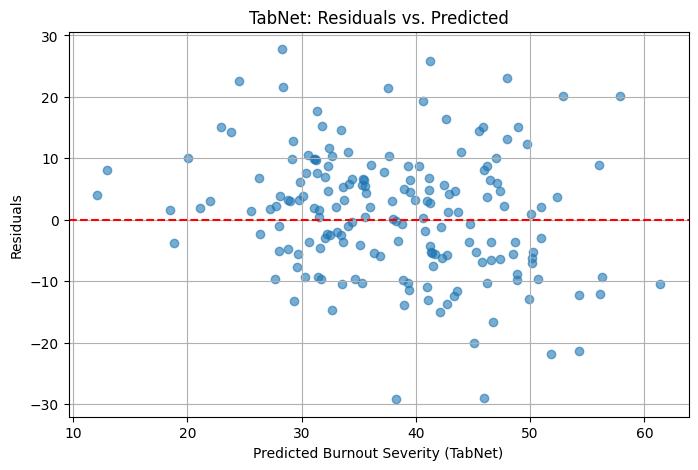

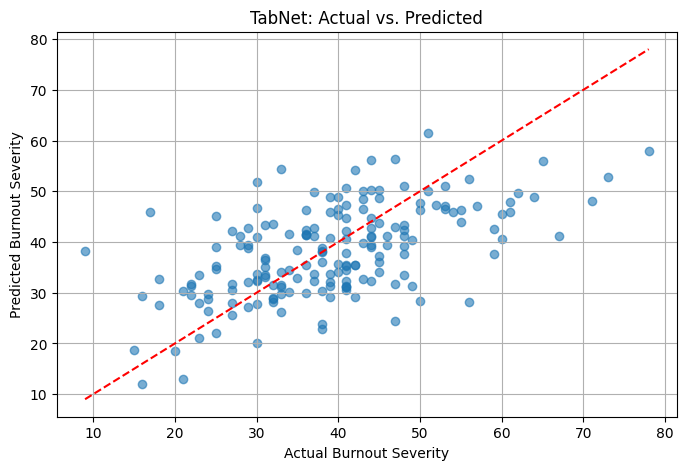

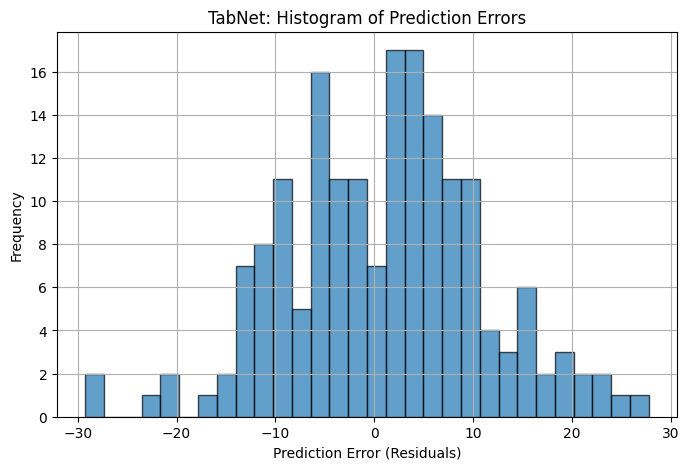

In [ ]:
# Error analysis TabNet ---------------------------------



# Ensure both predictions and test targets are 1D
y_pred_tabnet = y_pred_tabnet.flatten()
y_test_np = y_test_np.flatten()







# Recalculate residuals now that both are 1D
residuals_tabnet = y_test_np - y_pred_tabnet







# Residuals vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_tabnet, residuals_tabnet, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Burnout Severity (TabNet)")
plt.ylabel("Residuals")
plt.title("TabNet: Residuals vs. Predicted")
plt.grid(True)
plt.show()






# Actual vs. Predicted ----
plt.figure(figsize=(8, 5))
plt.scatter(y_test_np, y_pred_tabnet, alpha=0.6)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel("Actual Burnout Severity")
plt.ylabel("Predicted Burnout Severity")
plt.title("TabNet: Actual vs. Predicted")
plt.grid(True)
plt.show()







# Histogram of Residuals ----
plt.figure(figsize=(8, 5))
plt.hist(residuals_tabnet, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("TabNet: Histogram of Prediction Errors")
plt.grid(True)
plt.show()


# Best Model Feature Importance: SupportVectorRegression

         Feature  Importance
7     cesd_log_z    0.292149
8       stai_t_z    0.168190
14         sex_2    0.018080
1   stud_h_log_z    0.017838
0          age_z    0.006006
3     qcae_cog_z    0.005531
18      health_2    0.005261
21      health_5    0.003514
11        year_4    0.002679
5         amsp_z    0.002609


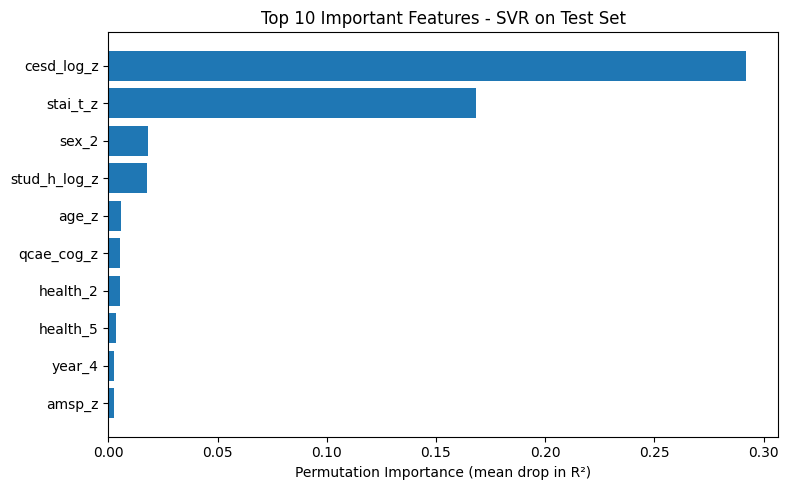

In [ ]:
# ------------------------------------------------------------------------------
# Best Model FEATURE IMPORTANCE   SVR Model
# ------------------------------------------------------------------------------




# Specifying target and predictors ------------


data = pd.read_csv("/content/drive/MyDrive/Master Thesis 2025/BurnoutDataset/data_encoded_clean.csv")

# Drop MBI-related columns
mbi_columns = ['mbi_ex', 'mbi_cy', 'mbi_ea', 'mbi_ea_rev', 'burnout']
df_filtered = data.drop(columns=mbi_columns)

# Define features and target
X = df_filtered.drop(columns=['mbi_total'])
y = df_filtered['mbi_total']

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.describe(), y_test.describe()




# ---------------------------------------------------
# SVR



# Best hyperparameters
svr = SVR(
    kernel='rbf',
    gamma=0.0017782794100389228,
    epsilon=0.12,
    C=35.93813663804626
)

# Fit the model
svr.fit(X_train, y_train)







# Permutation ------------------------------------



# Get permutation importance
result = permutation_importance(
    svr, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)





# Store in DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)





# Display top 10
print(perm_importance_df.head(10))







# Visualize -----------------------------------


plt.figure(figsize=(8, 5))
plt.barh(
    perm_importance_df['Feature'][:10][::-1],  # top 10 in reverse order for barh
    perm_importance_df['Importance'][:10][::-1]
)
plt.xlabel("Permutation Importance (mean drop in R²)")
plt.title("Top 10 Important Features - SVR on Test Set")
plt.tight_layout()
plt.show()
